# Test YOLO Semplificato

Questo notebook permette di:
1. **Testare YOLO pretrained** su una singola immagine
2. **Fine-tuning solo della head** (classification head) - molto più veloce!
3. **Visualizzare la struttura** del modello prima e dopo il freeze del backbone

In [21]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Configura matplotlib per notebook
%matplotlib inline

# Aggiungi il path del progetto
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from models.yolo_detector import YOLODetector
from config import Config

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Classi LineMOD: {Config.NUM_CLASSES}")
print(f"🖥️  Device: {Config.DEVICE}")

✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Classi LineMOD: 13
🖥️  Device: mps


In [8]:
# Carica yolo con pesi pretrained COCO (80 classi)
detector = YOLODetector(
    model_name='yolo11n',  # Nano version (più veloce)
    pretrained=True,
    num_classes=80  # COCO ha 80 classi
)

print(f"\n📊 Modello YOLO caricato:")
print(f"   Parametri totali: {detector.model_info['parameters']:,}")

# Mostra summary dettagliato del modello
print("\n📋 Model Summary (Layer Interni):")
print("="*80)
detector.model.info(verbose=False, detailed=True)  # verbose=True per vedere tutti i layer

✅ Loading pretrained yolo11n from cache: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pretrained/yolo11n.pt

📊 Modello YOLO caricato:
   Parametri totali: 2,624,080

📋 Model Summary (Layer Interni):


In [9]:
# Mostra summary del modello originale
print("📊 STRUTTURA MODELLO ORIGINALE (tutti i layer trainable)\n")
print("="*80)

# Conta parametri trainable
total_params = 0
trainable_params = 0

for name, param in detector.model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"\n📈 Statistiche parametri:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

# Mostra primi 20 layer
print(f"\n🔍 Layer del modello:")
print("-"*80)
for i, (name, param) in enumerate(list(detector.model.named_parameters())[:]):
    status = "✅ TRAINABLE" if param.requires_grad else "❄️  FROZEN"
    print(f"   {i:2d}. {name:50s} {status}  Shape: {tuple(param.shape)}")

📊 STRUTTURA MODELLO ORIGINALE (tutti i layer trainable)


📈 Statistiche parametri:
   Parametri totali: 2,624,080
   Parametri trainable: 0
   Percentuale trainable: 0.0%

🔍 Layer del modello:
--------------------------------------------------------------------------------
    0. model.model.0.conv.weight                          ❄️  FROZEN  Shape: (16, 3, 3, 3)
    1. model.model.0.bn.weight                            ❄️  FROZEN  Shape: (16,)
    2. model.model.0.bn.bias                              ❄️  FROZEN  Shape: (16,)
    3. model.model.1.conv.weight                          ❄️  FROZEN  Shape: (32, 16, 3, 3)
    4. model.model.1.bn.weight                            ❄️  FROZEN  Shape: (32,)
    5. model.model.1.bn.bias                              ❄️  FROZEN  Shape: (32,)
    6. model.model.2.cv1.conv.weight                      ❄️  FROZEN  Shape: (32, 32, 1, 1)
    7. model.model.2.cv1.bn.weight                        ❄️  FROZEN  Shape: (32,)
    8. model.model.2.cv1.bn.bias    

In [13]:
# Freeze del backbone (mantieni solo head trainable)
print("❄️  Congelamento del backbone in corso...\n")

# YOLO11n architecture (22 total layers, 0-21):
# - Layer 0-9:   Backbone (feature extraction - CSPDarknet) 
# - Layer 10-21: Neck + Head (feature fusion + detection)

# Congela i primi 10 layer (backbone) per nuova classificazione
freeze_until = 10 # Config.YOLO_FREEZE_UNTIL_LAYER  # 10 from config
stats = detector.freeze_backbone(freeze_until_layer=freeze_until)

print(f"\n✅ Backbone congelato fino al layer {freeze_until}")
print(f"   Layer {freeze_until}-21 sono trainable (neck/head)")

❄️  Congelamento del backbone in corso...

🔒 Freezing backbone until layer 10...

📊 Parameter Statistics:
   Total: 2,624,080
   Frozen: 1,115,744 (42.5%)
   Trainable: 1,508,336 (57.5%)

✅ Backbone frozen! Only detection head will be trained.

✅ Backbone congelato fino al layer 10
   Layer 10-21 sono trainable (neck/head)


In [14]:
from scripts.prepare_yolo_symlinks import prepare_yolo_dataset_symlinks, create_data_yaml

output_dir = Config.DATA_ROOT / 'yolo_symlinks'

# Prepara dataset se non esiste
if (output_dir / 'data.yaml').exists():
    print(f"✅ Dataset già preparato: {output_dir}")
    data_yaml_path = output_dir / 'data.yaml'
else:
    print("⚡ Preparazione dataset con symlinks...")
    stats = prepare_yolo_dataset_symlinks(
        dataset_root=Config.DATA_ROOT,
        output_root=output_dir,
        use_symlinks=True
    )
    print(f"\n✅ Dataset preparato in {stats['time_seconds']:.1f}s")
    print(f"   Train: {stats['train']} immagini")
    print(f"   Val: {stats['val']} immagini")
    
    data_yaml_path = create_data_yaml(output_dir, Config.DATA_ROOT)

print(f"\n📄 Config file: {data_yaml_path}")

✅ Dataset già preparato: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks

📄 Config file: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/data.yaml


In [15]:
# Training configuration
EPOCHS = 10  # Poche epoche per test veloce
BATCH_SIZE = 32
IMG_SIZE = 416
LR = 0.1

print(f"🚂 Configurazione training:")
print(f"   Epoche: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Image size: {IMG_SIZE}")
print(f"   Learning rate: {LR}")
print(f"   Device: {Config.DEVICE}")
print(f"\n⏱️  Tempo stimato: ~10-15 minuti")
print(f"   (circa 30-45 secondi per epoca)\n")

# Avvia training
results = detector.train(
    data_yaml=str(data_yaml_path),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch_size=BATCH_SIZE,
    lr0=LR,
    project=str(project_root / 'checkpoints' / 'yolo'),
    name='yolo_head_only',
    patience=10,
    save=True,
    cache=True,
    amp=True,
    workers=4,
    verbose=True
)

print(f"\n✅ Training completato!")
print(f"   Modello salvato in: checkpoints/yolo/yolo_head_only/")

🚂 Configurazione training:
   Epoche: 10
   Batch size: 32
   Image size: 416
   Learning rate: 0.1
   Device: mps

⏱️  Tempo stimato: ~10-15 minuti
   (circa 30-45 secondi per epoca)


🚂 Starting YOLO training...
   Model: yolo11n
   Epochs: 10
   Image size: 416
   Batch size: 32
   Device: mps
New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.13.3 torch-2.9.1 MPS (Apple M4 Pro)
Ultralytics 8.3.234 🚀 Python-3.13.3 torch-2.9.1 MPS (Apple M4 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/yolo_symlinks/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, 

✅ Carico modello fine-tuned: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_head_only5/weights/best.pt

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_head_only5/weights/best.pt
🔍 Rilevati 1 oggetti con modello fine-tuned:
   1. holepuncher: 0.87

📊 Visualizzazione detection...



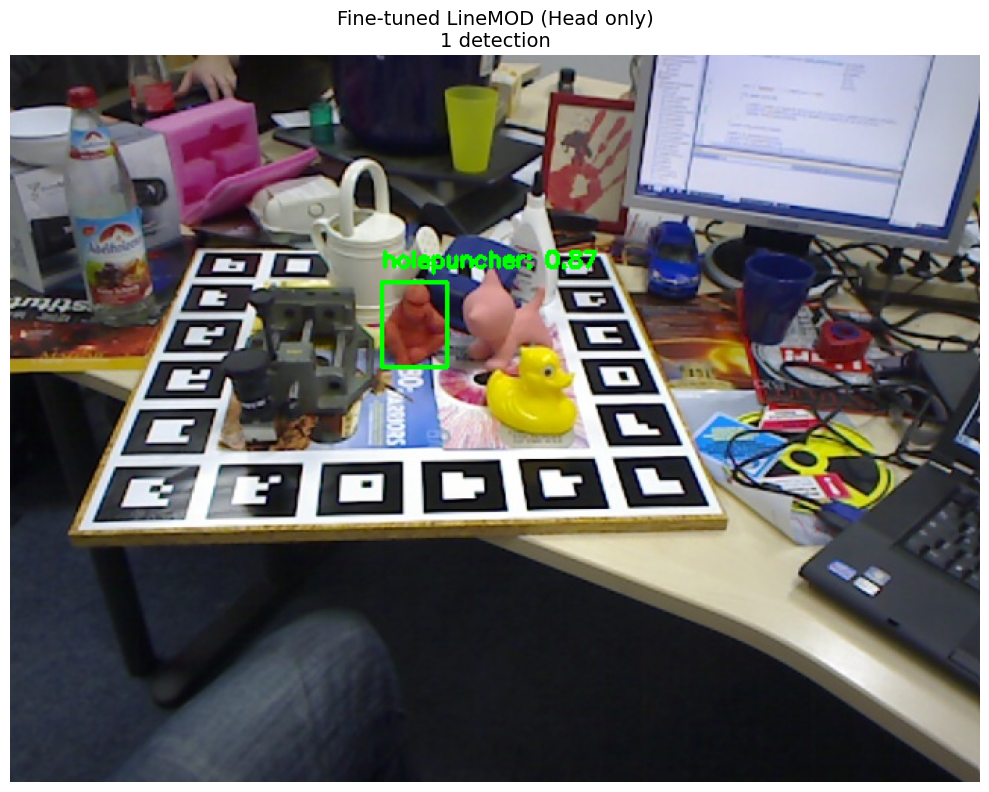

✅ Visualizzazione completata!


In [22]:
# Carica il modello fine-tuned
weights_path = project_root / 'checkpoints' / 'yolo' / 'yolo_head_only5' / 'weights' / 'best.pt'

if weights_path.exists():
    print(f"✅ Carico modello fine-tuned: {weights_path}\n")
    
    # Import necessari
    from models.yolo_detector import visualize_detections
    
    finetuned_detector = YOLODetector(
        model_name=str(weights_path),
        num_classes=Config.NUM_CLASSES
    )
    
    # Carica immagine di test se non già caricata
    if 'image' not in locals():
        img_path = Config.DATA_ROOT / 'data' / '01' / 'rgb' / '0000.png'
        image = np.array(Image.open(img_path).convert('RGB'))
        print(f"📷 Immagine caricata: {img_path.name}\n")
    
    # Test sulla stessa immagine
    detections_ft = finetuned_detector.detect_objects(image, conf_threshold=0.25)
    
    print(f"🔍 Rilevati {len(detections_ft)} oggetti con modello fine-tuned:")
    for i, det in enumerate(detections_ft):
        print(f"   {i+1}. {det['class_name']}: {det['confidence']:.2f}")
    
    print("\n📊 Visualizzazione detection...\n")
    
    # Visualizzazione
    vis_ft = visualize_detections(image.copy(), detections_ft)
    
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vis_ft)
    plt.title(f"Fine-tuned LineMOD (Head only)\n{len(detections_ft)} detection", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione completata!")
else:
    print(f"❌ Modello non trovato: {weights_path}")
    print("   Esegui prima il training (cella precedente)")